# Code to produce figure 6

__Zoïs Moitier__
            
_Karlsruhe Institute of Technology, Germany_

In [1]:
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))
import src.helmholtz as hel
import src.utils as utils

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LogNorm

%matplotlib inline

## Internal plotting functions

In [3]:
def calc_err(result, tt_trace, bdy_type):
    θ = result.grid
    if bdy_type == hel.BoundaryType.DIRICHLET:
        u_ana = tt_trace[1](θ)
        u_num = result.scaled_normal_trace
    else:
        u_ana = tt_trace[0](θ)
        u_num = result.trace

    return np.abs(u_num - u_ana).max() / np.abs(u_ana).max()

In [4]:
def plot_err_2d(param):
    ɛ_vec = param["ɛ_vec"]
    ɛ_str = param["ɛ_str"]
    bdy_type = param["bdy_type"]

    α_vec = param["α_vec"]
    α_str = param["α_str"]
    k = param["k"]

    M = param["M"]
    N = param["N"]

    err = np.empty((len(ɛ_vec), len(α_vec)))

    for i, ɛ in enumerate(ɛ_vec):
        obs = hel.create_obstacle(ɛ=ɛ, bdy_type=bdy_type)

        for j, α in enumerate(α_vec):
            in_field = hel.analytic.plane_wave_field(obs, α, k, M)
            sc_field = hel.analytic.get_scatter_field(obs, in_field)
            tt_trace = hel.get_total_trace(obs, in_field, sc_field)

            err[i, j] = calc_err(
                hel.bie.get_total_field_qpax(
                    obs, k, hel.get_incident_trace_expansion(in_field), N
                ),
                tt_trace,
                bdy_type,
            )

    fig_size = [1.25 * e for e in [6.4, 4.8]]
    fig, ax = plt.subplots(figsize=fig_size, constrained_layout=True)

    log_norm_err = LogNorm(err.min(), err.max())
    sns.heatmap(
        err,
        ax=ax,
        cmap="YlGnBu_r",
        norm=log_norm_err,
        xticklabels=α_str,
        yticklabels=ɛ_str,
    )
    ax.set_xlabel(r"$\alpha$", fontsize=15)
    ax.set_ylabel(r"$\varepsilon$", fontsize=15)
    ax.set_aspect("equal", "box")

    cbar_ax = fig.axes[-1]
    cbar_ax.tick_params(which="minor", length=0)

    plt.show()

    return None

In [5]:
def plot_angle(param):
    bdy_type = param["bdy_type"]
    nb_ɛ = 16
    ɛ_min, ɛ_max = 1e-8, 0.9
    ɛ_vec = np.geomspace(ɛ_min, ɛ_max, num=nb_ɛ)

    k = param["k"]

    m = param["m"]
    N = param["N"]

    err = np.zeros((nb_ɛ, len(param["angles"])))

    for j, α in enumerate(param["angles"]):
        for i, ɛ in enumerate(ɛ_vec):
            obs = hel.create_obstacle(ɛ=ɛ, bdy_type=bdy_type)
            in_field = hel.analytic.plane_wave_field(obs, α, k, M)
            sc_field = hel.analytic.get_scatter_field(obs, in_field)
            tt_trace = hel.get_total_trace(obs, in_field, sc_field)

            err[i, j] = calc_err(
                hel.bie.get_total_field_qpax(
                    obs, k, hel.get_incident_trace_expansion(in_field), N
                ),
                tt_trace,
                bdy_type,
            )

    fig_size = [1.25 * e for e in [6.4, 4.8]]
    fig, ax = plt.subplots(figsize=fig_size, constrained_layout=True)

    marker_vec = (".", "+", "*", "x")
    for n, leg in enumerate(param["angles_str"]):
        ax.loglog(ɛ_vec, err[:, n], f"{marker_vec[n]}--", lw=2, label=leg)

    if param["slope"][0]:
        ɛ_ = np.array([1e-8, 1e-3])
        ax.loglog(ɛ_, 10 ** (-1) * ɛ_, "k", label=r"$\mathcal{O}(\varepsilon)$")

    if param["slope"][1]:
        ɛ_ = np.array([1e-7, 1e-3])
        ax.loglog(
            ɛ_, 10 ** (-0.5) * ɛ_**2, "k--", label=r"$\mathcal{O}(\varepsilon^2)$"
        )

    ax.set_xlim(1e-8 / 10**0.5, 1 * 10**0.5)
    ax.set_xlabel(r"$\varepsilon$", fontsize=15)
    ax.set_ylim(1e-16 / 10, 10)
    ax.set_ylabel("relative error", fontsize=15)
    ax.grid(True)
    ax.legend(loc=4, fontsize=15)

    ax.minorticks_off()

    plt.show()

    return None

## Parameters

In [6]:
## Incident field parameters
k = 2  # wavenumber direction of the plane wave
M = 15  # 2M+1 number of mode in the analytic sum

In [7]:
## Discretization parameters
N = 64  # Number of quadrature points

α_min, α_max = 16, 512
nb_α = 8
α_ = [f"{x:.2f}" for x in np.linspace(0, 0.5, num=nb_α)]
α_vec = [float(s) * np.pi for s in α_]
α_str = [rf"${s}\pi$" for s in α_]

ɛ_min, ɛ_max = 1e-8, 0.9
nb_ɛ = 8
ɛ_vec = utils.logspace_epsilon(ɛ_min, ɛ_max, nb_ɛ)[::-1]
ɛ_str = [f"{x:.1e}" for x in ɛ_vec]

## Neuman boundary condition

### Heatmap of the relative error for different directions

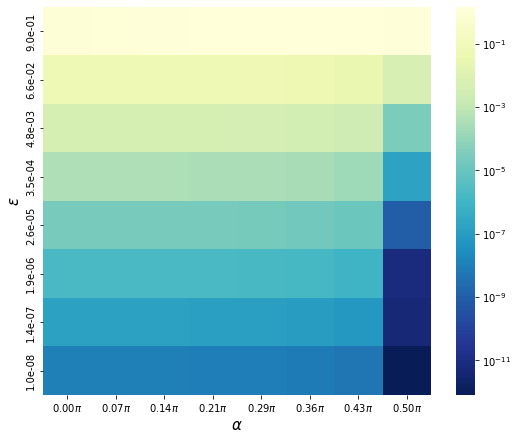

In [8]:
plot_err_2d(
    {
        "bdy_type": hel.BoundaryType.NEUMANN,
        "ɛ_vec": ɛ_vec,
        "ɛ_str": ɛ_str,
        "α_vec": α_vec,
        "α_str": α_str,
        "k": k,
        "M": M,
        "N": N,
    }
)

### Convergence plot of the relative error for different directions

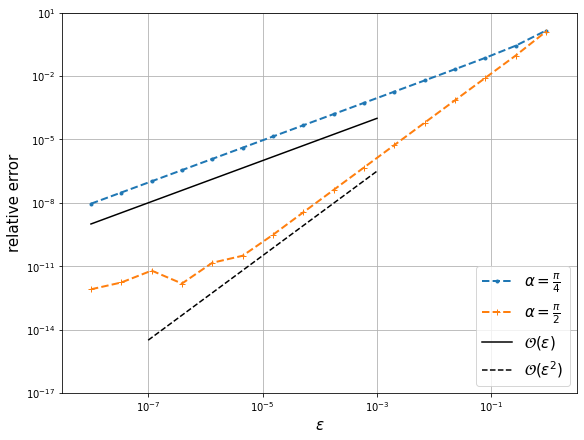

In [9]:
plot_angle(
    {
        "bdy_type": hel.BoundaryType.NEUMANN,
        "k": k,
        "m": 15,
        "angles": [np.pi / q for q in [4, 2]],
        "angles_str": [rf"$\alpha = \frac{{\pi}}{{{q}}}$" for q in [4, 2]],
        "N": 64,
        "slope": (True, True),
    }
)

## Dirichlet boundary condition

### Heatmap of the relative error for different directions

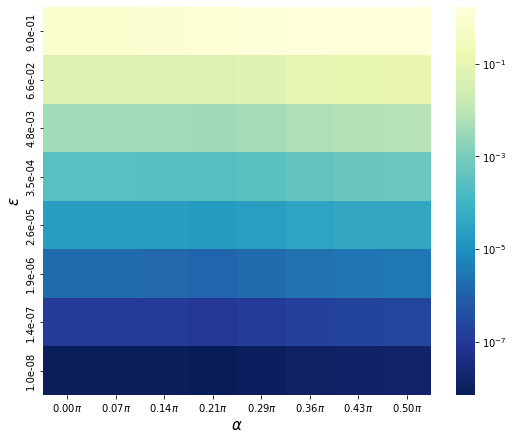

In [10]:
plot_err_2d(
    {
        "bdy_type": hel.BoundaryType.DIRICHLET,
        "ɛ_vec": ɛ_vec,
        "ɛ_str": ɛ_str,
        "α_vec": α_vec,
        "α_str": α_str,
        "k": k,
        "M": M,
        "N": N,
    }
)

### Convergence plot of the relative error for different directions

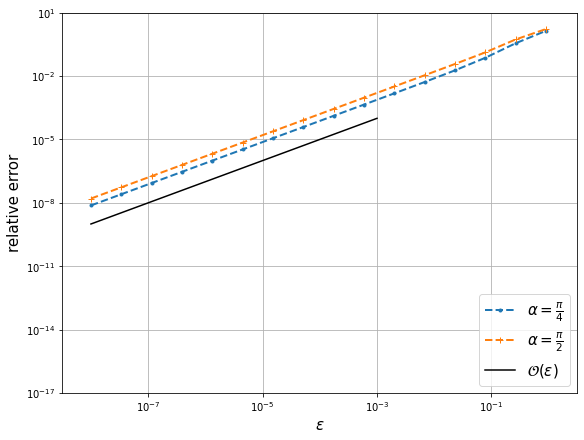

In [11]:
plot_angle(
    {
        "bdy_type": hel.BoundaryType.DIRICHLET,
        "k": k,
        "m": 15,
        "angles": [np.pi / q for q in [4, 2]],
        "angles_str": [rf"$\alpha = \frac{{\pi}}{{{q}}}$" for q in [4, 2]],
        "N": 64,
        "slope": (True, False),
    }
)